# FQI on Bicycle

## Define parameters

In [12]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]
# Sample collection
n_samples = parameters["n_samples"]

# Trainings
layers_dimension = parameters["layers_dimension"]
max_bellman_iterations = parameters["max_bellman_iterations"]
batch_size_samples = n_samples
fitting_steps = parameters["fitting_steps_fqi"]
learning_rate = {"first": parameters["starting_lr_fqi"], "last": parameters["ending_lr_fqi"], "duration": fitting_steps * n_samples // batch_size_samples}
max_patience = parameters["patience"]

# Visualisation of errors and performances
n_omegas = parameters["n_omegas"]
n_thetas = parameters["n_thetas"]
n_simulations = parameters["n_simulations"]
horizon = parameters["horizon"]

# Search for an unused seed
max_used_seed = 0
if not os.path.exists("figures/data/FQI/"):
    os.makedirs("figures/data/FQI/")
for file in os.listdir("figures/data/FQI/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
seed = max_used_seed + 1
env_key = jax.random.PRNGKey(env_seed)
env_key, sample_key = jax.random.split(env_key)
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, _ = jax.random.split(key, 3) # 3 keys are generated to be coherent with the other trainings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [13]:
import numpy as np

from pbo.environments.bicycle import BicycleEnv


env = BicycleEnv(env_key, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [14]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
positions = [[env.position]]

for idx_sample in range(n_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    action = jax.random.choice(key, env.actions_on_max)
    
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1
    positions[n_episodes].append(env.position)

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing[0] or n_steps >= 20:
        env.reset()
        positions[n_episodes] = np.array(positions[n_episodes])
        positions.append([])
        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
# assert sum(replay_buffer.rewards == -1) > 0, "No negative reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 375


### Visualize samples

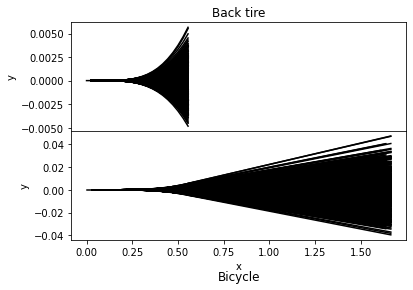

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for episode in range(n_episodes):
    ax1.plot(positions[episode][:, 0], positions[episode][:, 1], color="black")

    for step in range(len(positions[episode])):
        ax2.plot(positions[episode][step, [0, 2]], positions[episode][step, [1, 3]], color="black")


ax1.get_xaxis().set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylabel("y")
ax1.set_title(f"Back tire")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title(f"Bicycle", y=0, pad=-30, verticalalignment="top")

plt.subplots_adjust(hspace=0)

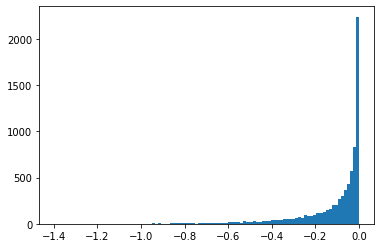

In [16]:
omegas = jnp.linspace(replay_buffer.states[:, 0].min(), replay_buffer.states[:, 0].max(), n_omegas)
omega_dots = jnp.linspace(replay_buffer.states[:, 1].min(), replay_buffer.states[:, 1].max(), n_omegas)

sample_key, key = jax.random.split(sample_key)
sample_omegas_omega_dots = jax.random.choice(key, replay_buffer.states[:, :2], shape=(min(n_samples // 100, 50),), replace=False)

thetas = jnp.linspace(replay_buffer.states[:, 2].min(), replay_buffer.states[:, 2].max(), n_thetas)
theta_dots = jnp.linspace(replay_buffer.states[:, 3].min(), replay_buffer.states[:, 3].max(), n_thetas)

sample_key, key = jax.random.split(sample_key)
sample_thetas_theta_dots = jax.random.choice(key, replay_buffer.states[:, 2:5], shape=(min(n_samples // 100, 50),), replace=False)

_ = plt.hist(np.array(replay_buffer.rewards.flatten()), 100)

## Train FQI

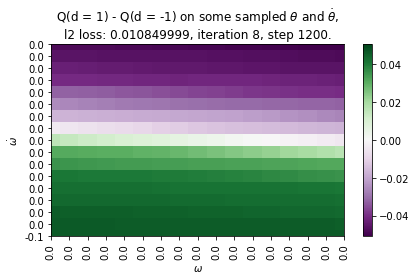

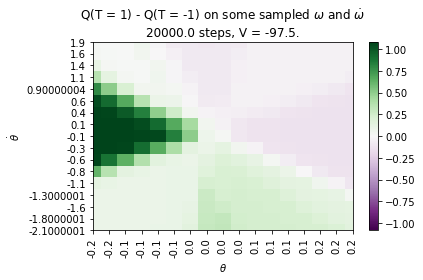

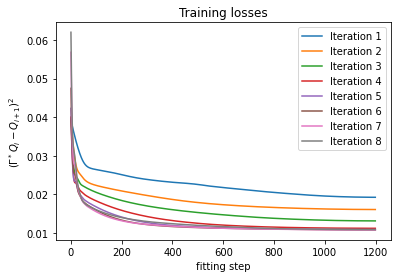

In [17]:
import matplotlib.pyplot as plt

from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=4,
    action_dim=2,
    actions_on_max=env.actions_on_max,
    gamma=gamma,
    network_key=q_network_key,
    layers_dimension=layers_dimension,
    zero_initializer=True,
    learning_rate=learning_rate
)

omega_visu_mesh = TwoDimesionsMesh(omegas, omega_dots, sleeping_time=0, axis_equal=False, zero_centered=True)
theta_visu_mesh = TwoDimesionsMesh(thetas, theta_dots, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations, fitting_steps)) * np.nan
metrics = np.ones((max_bellman_iterations + 1, n_simulations, 2)) * np.nan
metrics[0] = env.evaluate(q, q.params, horizon, n_simulations)

for bellman_iteration in range(1, max_bellman_iterations + 1):
    q.reset_optimizer()
    params_target = q.params
    best_loss = float('inf')
    patience = 0

    for step in range(fitting_steps):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration - 1, step] = cumulative_l2_loss
        if cumulative_l2_loss < best_loss:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1

        if patience > max_patience:
            break

    metric = env.evaluate(q, q.params, horizon, n_simulations)
    metrics[bellman_iteration] = metric

    d_on_omegas = env.q_values_on_omegas(q, q.params, omegas, omega_dots, sample_thetas_theta_dots)
    T_on_thetas = env.q_values_on_thetas(q, q.params, sample_omegas_omega_dots, thetas, theta_dots)

    omega_visu_mesh.set_values(d_on_omegas)
    omega_visu_mesh.show(r"Q(d = 1) - Q(d = -1) on some sampled $\theta$ and $\dot{\theta}$," + f"\nl2 loss: {str(jnp.round(cumulative_l2_loss, 5))}, iteration {bellman_iteration}, step {step + 1}.", xlabel=r"$\omega$", ylabel=r"$\dot{\omega}$")
    theta_visu_mesh.set_values(T_on_thetas)
    theta_visu_mesh.show(r"Q(T = 1) - Q(T = -1) on some sampled $\omega$ and $\dot{\omega}$" + f"\n{metric[:, 0].mean()} steps, V = {str(jnp.round(metric[:, 1].mean(), 1))}.", xlabel=r"$\theta$", ylabel=r"$\dot{\theta}$", clear=False)


for bellman_iteration in range(0, max_bellman_iterations, max(max_bellman_iterations // 10, 1)):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

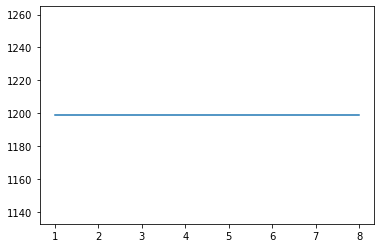

In [18]:
plt.plot(range(1, max_bellman_iterations + 1), [np.argmin(l) for l in l2_losses])

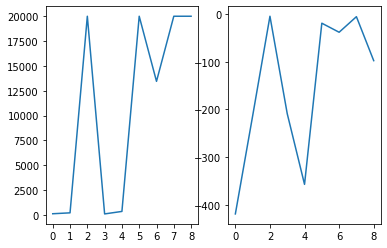

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(range(max_bellman_iterations + 1), metrics[:, :, 0].mean(axis=1))
ax1.set_xticks(range(max_bellman_iterations + 1))
ax2.plot(range(max_bellman_iterations + 1), metrics[:, :, 1].mean(axis=1))

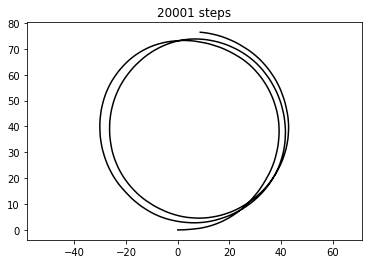

In [21]:
positions = env.collect_positions(q, q.params, horizon)

plt.plot(positions[:, 0], positions[:, 1], color="black")
plt.axis("equal")
_ = plt.title(f"{positions.shape[0]} steps")

In [22]:
# env.simulate(q, q.params, horizon, 0, 0)

## Save the data

In [24]:
np.save(f"figures/data/FQI/{max_bellman_iterations}_metrics_{seed}.npy", metrics)